# Выбор локации для скважины

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Ключевые значения для расчетов

In [1]:
# количество лучших выбранных скважин 
count_wells = 200

# бюджет на разработку скважин в регионе
budget = 10 * 10**9

# доход с каждой единицы продукта 
income_from_each_unit = 450000

# 500 точек от 25000 находящихся в валидационной выборке есть 2% или 0.02
fraction = .02

### Обзор данных 

По первому взгляду можно сказать, что предстоит решить задачу регрессии, пропуски в данных отсутствуют, кодирование проводить не следует ввиду отсутствия категориальных признаков, следует провести обучение моделей, не учитывая признак 'id', он не будет влиять на предсказания сырья.

In [5]:
# импортирование всех нужных библиотек и фуцнкций 
import pandas as pd 
import numpy as np
from scipy import stats as st

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [6]:
# формирование датафреймов
geo_data_0 = pd.read_csv('dataset_geo_0.csv', index_col=0)
geo_data_1 = pd.read_csv('dataset_geo_1.csv', index_col=0)
geo_data_2 = pd.read_csv('dataset_geo_2.csv', index_col=0)

# просмотр общей информации о датафреймах
display(geo_data_0.head())
display(geo_data_1.head())
display(geo_data_2.head())
geo_data_0.info()
geo_data_1.info()
geo_data_2.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

## Обучение и проверка модели

### Обучающая и валидационная выборки

На первом регионе:

In [3]:
# функция для формирования признаков и целевого признака на обучающей и валидационной выборках
def set_features_and_target(data):
    
    # разделение на обучающую и валидационную выборки
    data_train, data_valid = train_test_split(data, test_size=0.25, random_state=123)
    
    # признаки и целевой признак обучающей выборки
    features_train = data_train.drop(['id', 'product'], axis=1)
    target_train = data_train['product']
    
    # признаки и целевой признак валидационной выборки
    features_valid = data_valid.drop(['id', 'product'], axis=1)  
    target_valid = data_valid['product']
    
    return features_train, target_train, features_valid, target_valid

# признаки и целевой признак в первом регионе
features_train_geo_0, target_train_geo_0, features_valid_geo_0, target_valid_geo_0 = set_features_and_target(geo_data_0)

# признаки и целевой признак во втором регионе
features_train_geo_1, target_train_geo_1, features_valid_geo_1, target_valid_geo_1 = set_features_and_target(geo_data_1)

# признаки и целевой признак в третьем регионе
features_train_geo_2, target_train_geo_2, features_valid_geo_2, target_valid_geo_2 = set_features_and_target(geo_data_2)

### Обучение модели

Кросс-валидация уже используется в модели подбора гиперпараметров GridSearchCV.

In [4]:
# вариации гиперпараметров
fit_intercept = [True, False]
normalize = [True, False]

# сетка гиперпараметров
parameters_grid = {'fit_intercept':fit_intercept,
                   'normalize':normalize}

# модели 'линейная регрессия'
model_geo_0 = GridSearchCV(LinearRegression(), parameters_grid, scoring='neg_root_mean_squared_error', cv=5)
model_geo_1 = GridSearchCV(LinearRegression(), parameters_grid, scoring='neg_root_mean_squared_error', cv=5)
model_geo_2 = GridSearchCV(LinearRegression(), parameters_grid, scoring='neg_root_mean_squared_error', cv=5)

# обучение моделей
model_geo_0.fit(features_train_geo_0, target_train_geo_0)
model_geo_1.fit(features_train_geo_1, target_train_geo_1)
model_geo_2.fit(features_train_geo_2, target_train_geo_2)

# наилучшие гиперпараметры моделей
display(model_geo_0.best_params_)
display(model_geo_1.best_params_)
display(model_geo_2.best_params_)

{'fit_intercept': True, 'normalize': True}

{'fit_intercept': True, 'normalize': True}

{'fit_intercept': True, 'normalize': True}

### Предсказания и правильные ответы на валидационной выборке

In [5]:
# предсказания на валидационной выборке 
predictions_valid_geo_0 = pd.Series(model_geo_0.predict(features_valid_geo_0))
predictions_valid_geo_1 = pd.Series(model_geo_1.predict(features_valid_geo_1))
predictions_valid_geo_2 = pd.Series(model_geo_2.predict(features_valid_geo_2))

# объем сырья с сброшенным индексом для проведения техники bootstrap
target_new_indexes_0 = target_valid_geo_0.reset_index(drop=True)
target_new_indexes_1 = target_valid_geo_1.reset_index(drop=True)
target_new_indexes_2 = target_valid_geo_2.reset_index(drop=True)

### Средний запас сырья и RMSE модели

Модели обученные на первом и третьем регионах показывают достаточно большой корень из среднеквадратичной ошибки, учитывая среднее значение предсказаний. Модель на втором регионе, наоборот, маленькую ошибку.

In [6]:
# предсказанный средний запас сырья 
display(predictions_valid_geo_0.mean())

# корень из среднеквадратичной ошибки (RMSE)
display(mean_squared_error(target_valid_geo_0, predictions_valid_geo_0, squared=False))

92.54936189116309

37.64786282376177

In [7]:
# предсказанный средний запас сырья 
display(predictions_valid_geo_1.mean())

# корень из среднеквадратичной ошибки (RMSE)
display(mean_squared_error(target_valid_geo_1, predictions_valid_geo_1, squared=False))

69.28001860653976

0.8954139804944313

In [8]:
# предсказанный средний запас сырья 
display(predictions_valid_geo_2.mean())

# корень из среднеквадратичной ошибки (RMSE)
display(mean_squared_error(target_valid_geo_2, predictions_valid_geo_2, squared=False))

95.09859933591373

40.12803006598514

## Подготовка к расчёту прибыли

### Достаточный объем сырья для безубыточной разработки 

Не менее 112 единиц - минимальный объем сырья в скважине для безубыточной разработки. <br>

In [9]:
# минимальное количество единиц сырья
min_volume = budget / count_wells / income_from_each_unit

display(min_volume)

111.11111111111111

### Выводы по этапу подготовки расчета прибыли

Средние значения сырья в первом и третьем регионе ниже на 15%, чем найденное минимальное значение.<br>
Ситуация со вторым регионом иная - среднее значение ниже на 40%. <br><br>
Интересно, что второй регион имеет необычное распределение по сравнению с более стандартизированными распределениями первого и третьего регионов.

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

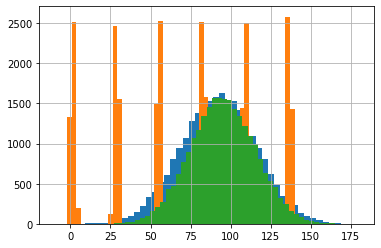

In [10]:
# распределение предсказанного сырья 
display(predictions_valid_geo_0.hist(bins=50))
display(predictions_valid_geo_1.hist(bins=50))
display(predictions_valid_geo_2.hist(bins=50))

### Функция для расчета прибыли 

In [11]:
def total_income(target, predictions):
    # сортированный по убыванию объект Series с предсказанным сырьем 
    wells_sorted = predictions.sort_values(ascending=False)
    
    # объект Series составленный по индексам наибольших предсказанных значений 
    income = target[wells_sorted.index][:count_wells]
    
    return income.sum() * income_from_each_unit - budget

## Расчёт прибыли и рисков 

### Применение техники Bootstrap

По всем трем регионам распределение прибыли соответствует нормальному распределению.

In [12]:
# функция для формирования распределения прибыли
def set_scatter_income(target, predictions):
    
    # параметр определяющий случайность для каждой подвыборки
    state = np.random.RandomState(12345)
    
    # список с прибылью
    values = []
    
    for i in range(1000):
        
        # создание подвыборки в ключевых признаках 
        target_subsample = target.sample(replace=True, frac=fraction, random_state=state)

        # создание подвыборки в предсказаниях с индексацией подвыборки ключевых признаков 
        pred_subsample = predictions[target_subsample.index]

        # добавление в список значения прибыли
        values.append(total_income(target_subsample, pred_subsample))

    # изменение списка на объект Series
    return pd.Series(values)

<AxesSubplot:>

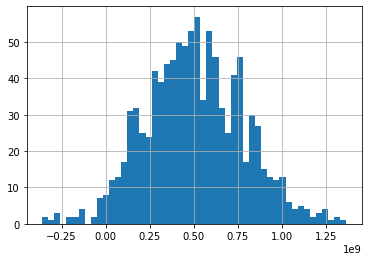

In [13]:
# список с прибылью
values_0 = set_scatter_income(target_new_indexes_0, predictions_valid_geo_0)

# средняя прибыль
mean_income_0 = values_0.mean()

# гистограмма с распределением прибыли 
display(values_0.hist(bins=50))

<AxesSubplot:>

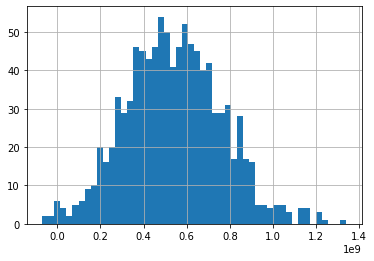

In [14]:
# список с прибылью
values_1 = set_scatter_income(target_new_indexes_1, predictions_valid_geo_1)

# средняя прибыль
mean_income_1 = values_1.mean()

# гистограмма с распределением прибыли 
display(values_1.hist(bins=50))

<AxesSubplot:>

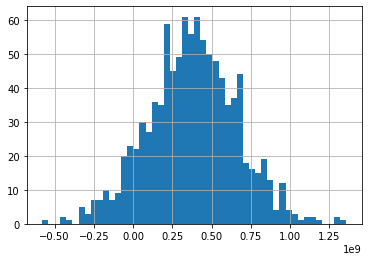

In [15]:
# список с прибылью
values_2 = set_scatter_income(target_new_indexes_2, predictions_valid_geo_2)

# средняя прибыль
mean_income_2 = values_2.mean()

# гистограмма с распределением прибыли 
display(values_2.hist(bins=50))

### Средняя прибыль, 95%-й интервал и риск убытков

#### Средняя прибыль

* Первый регион: 505 миллионов. 
* Второй регион: 541 миллион.
* Третий регион: 377 миллионов. 

In [16]:
display(mean_income_0 / 10**6)
display(mean_income_1 / 10**6)
display(mean_income_2 / 10**6)

505.2647037061952

541.3460191680023

377.5948832245889

#### 95%-й доверительный интервал

* В первом регионе: от 488 до 522 миллионов. 
* Во втором регионе: от 527 до 555 миллионов. 
* В третьем регионе: от 359 до 395 миллионов. 

In [17]:
# расчет доверительного интервала
confidence_interval_0 = st.t.interval(alpha=0.95, df=len(values_0)-1, loc=mean_income_0, scale=values_0.sem())

display(confidence_interval_0)

(488019000.64139795, 522510406.7709924)

In [18]:
# расчет доверительного интервала
confidence_interval_1 = st.t.interval(alpha=0.95, df=len(values_1)-1, loc=mean_income_1, scale=values_1.sem())

display(confidence_interval_1)

(527446528.1834567, 555245510.1525477)

In [19]:
# расчет доверительного интервала
confidence_interval_2 = st.t.interval(alpha=0.95, df=len(values_2)-1, loc=mean_income_2, scale=values_2.sem())

display(confidence_interval_2)

(359999059.56139374, 395190706.887784)

#### Риск убытков

* В первом регионе: меньше 2.5%. 
* Во втором регионе: меньше 0.5%. 
* В третьем регионе: меньше 5%. 

По условию задачи необходимо оставить регионы, в которых вероятность убытков менее 2.5%, это первый и второй регионы.

In [20]:
# список с квантилями, при которых будет убыток 
chances = []

# цикл для перебора квантилей, при которых разработка осуществляется в убыток
for i in np.arange(.005, .051, .0001):
    
    # проверка на отрицательность разработки 
    if values_0.quantile(i) < 0:
        
        # добавление квантиля с отрицательной прибылью в список
        chances.append(i)

# определение порогового квантиля 
display(max(chances) * 100)

2.5200000000000053

In [21]:
# список с квантилями, при которых будет убыток 
chances = []

# цикл для перебора квантилей, при которых разработка осуществляется в убыток
for i in np.arange(.005, .051, .0001):
    
    # проверка на отрицательность разработки 
    if values_1.quantile(i) < 0:
        
        # добавление квантиля с отрицательной прибылью в список
        chances.append(i)
        
# определение порогового квантиля 
display(max(chances) * 100)

0.5300000000000001

In [22]:
# список с квантилями, при которых будет убыток 
chances = []

# цикл для перебора квантилей, при которых разработка осуществляется в убыток
for i in np.arange(.005, .051, .0001):
    
    # проверка на отрицательность разработки 
    if values_2.quantile(i) < 0:
        
        # добавление квантиля с отрицательной прибылью в список
        chances.append(i)
        
# определение порогового квантиля 
display(max(chances) * 100)

5.090000000000012

### Выбор региона 

**Второй регион является наилучшим вариантом для разработки скважин**, так как он показывает наибольшую среднюю прибыль (541 миллион) и имеет наименьшую вероятность убытков, а именно 0.5%.